In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.cluster import KMeans

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import math 
import wrangle_functions
import env
import acquire
import prepare

In [2]:
############################################################################### ACQUIRE

In [3]:
# use zillow;
# from acquire.py

#acquire.get_connection('zillow')
    

def new_zillow_data():
    df = pd.read_sql('''SELECT *
    FROM properties_2017
    LEFT OUTER JOIN airconditioningtype 
    USING(airconditioningtypeid) 
    LEFT OUTER JOIN architecturalstyletype
    USING(architecturalstyletypeid) 
    LEFT OUTER JOIN buildingclasstype 
    USING(buildingclasstypeid) 
    LEFT OUTER JOIN heatingorsystemtype
    USING(heatingorsystemtypeid) 
    LEFT OUTER JOIN predictions_2017
    ON predictions_2017.id = properties_2017.id
    INNER JOIN (
    SELECT id, MAX(transactiondate) as last_trans_date 
    FROM predictions_2017
    GROUP BY id
    ) predictions ON predictions.id = properties_2017.id AND predictions_2017.transactiondate = predictions.last_trans_date
    LEFT OUTER JOIN propertylandusetype
    USING(propertylandusetypeid)
      LEFT OUTER JOIN storytype
    USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
    USING(typeconstructiontypeid)
    JOIN unique_properties
      ON unique_properties.parcelid = properties_2017.parcelid
    WHERE latitude IS NOT NULL and longitude IS NOT NULL;''', acquire.get_connection('zillow'))
    return df

In [4]:
df = new_zillow_data()

In [5]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc,parcelid
0,NaN,NaN,269.00,NaN,NaN,NaN,NaN,0,10754147,NaN,...,0,14297519,0.03,2017-01-01,0,2017-01-01,Planned Unit Development,None,None,10754147
1,NaN,NaN,261.00,NaN,NaN,NaN,NaN,1,10759547,NaN,...,1,17052889,0.06,2017-01-01,1,2017-01-01,Single Family Residential,None,None,10759547
2,NaN,NaN,47.00,NaN,5.00,NaN,NaN,2,10843547,NaN,...,2,14186244,0.01,2017-01-01,2,2017-01-01,Store/Office (Mixed Use),None,None,10843547
3,NaN,NaN,47.00,NaN,3.00,NaN,NaN,3,10859147,NaN,...,3,12177905,-0.10,2017-01-01,3,2017-01-01,Store/Office (Mixed Use),None,None,10859147
4,NaN,NaN,31.00,NaN,4.00,NaN,NaN,4,10879947,NaN,...,4,10887214,0.01,2017-01-01,4,2017-01-01,Commercial/Office/Residential Mixed Used,None,None,10879947


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77614 entries, 0 to 77613
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        166 non-null    float64
 1   storytypeid                   45 non-null     float64
 2   propertylandusetypeid         77614 non-null  float64
 3   heatingorsystemtypeid         48475 non-null  float64
 4   buildingclasstypeid           383 non-null    float64
 5   architecturalstyletypeid      151 non-null    float64
 6   airconditioningtypeid         21457 non-null  float64
 7   id                            77614 non-null  int64  
 8   parcelid                      77614 non-null  int64  
 9   basementsqft                  45 non-null     float64
 10  bathroomcnt                   77614 non-null  float64
 11  bedroomcnt                    77614 non-null  float64
 12  buildingqualitytypeid         50322 non-null  float64
 13  c

In [7]:
df.describe()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,id,parcelid
count,166.00,45.00,"77,614.00","48,475.00",383.00,151.00,"21,457.00","77,614.00","77,614.00",45.00,...,"77,614.00","76,003.00","77,103.00","1,505.00","75,519.00","77,614.00","77,614.00","77,614.00","77,614.00","77,614.00"
mean,5.99,7.00,259.94,4.04,3.78,7.43,1.93,"38,806.50","13,379,428.47",593.13,...,"2,016.00","265,047.58","5,371.52",13.91,"60,489,761,355,119.06","38,806.50","13,007,807.98",0.02,"38,806.50","13,379,428.47"
std,0.16,0.00,16.97,3.23,0.46,2.63,3.13,"22,405.38","8,351,447.64",460.92,...,0.07,"528,079.16","10,407.55",1.54,"210,075,285,376.01","22,405.38","3,518,694.35",0.17,"22,405.38","8,351,447.64"
min,4.00,7.00,31.00,1.00,1.00,2.00,1.00,0.00,"10,711,745.00",63.00,...,"2,003.00",4.00,2.54,6.00,"60,371,011,101,000.00",0.00,"10,711,855.00",-4.66,0.00,"10,711,745.00"
25%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"19,403.25","11,585,723.50",220.00,...,"2,016.00","78,406.50","2,449.60",14.00,"60,373,106,017,007.00","19,403.25","11,538,214.00",-0.02,"19,403.25","11,585,723.50"
50%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"38,806.50","12,532,247.00",540.00,...,"2,016.00","175,342.00","4,006.66",14.00,"60,375,718,002,010.00","38,806.50","12,530,061.50",0.01,"38,806.50","12,532,247.00"
75%,6.00,7.00,261.00,7.00,4.00,7.00,1.00,"58,209.75","14,115,087.00",732.00,...,"2,016.00","324,677.00","6,198.60",15.00,"60,590,423,262,017.00","58,209.75","14,211,001.25",0.04,"58,209.75","14,115,087.00"
max,6.00,7.00,275.00,24.00,5.00,21.00,13.00,"77,613.00","169,601,949.00","2,443.00",...,"2,016.00","94,011,079.00","1,824,154.85",15.00,"61,110,091,003,005.00","77,613.00","167,689,317.00",5.26,"77,613.00","169,601,949.00"


In [8]:
df.shape

(77614, 73)

In [9]:
df.dtypes

typeconstructiontypeid    float64
storytypeid               float64
propertylandusetypeid     float64
heatingorsystemtypeid     float64
buildingclasstypeid       float64
                           ...   
last_trans_date            object
propertylandusedesc        object
storydesc                  object
typeconstructiondesc       object
parcelid                    int64
Length: 73, dtype: object

In [10]:
# create list of single unit propertylandusedesc
single_prop_types = ['Single Family Residential', 'Condominium', 'Mobile Home',
                     'Manufactured, Modular, Prefabricated Homes', 'Townhouse']
# filter for most-likely single unit properties
df = df[df.propertylandusedesc.isin(single_prop_types)]
df = df[(df.bedroomcnt > 0) & (df.bedroomcnt <= 10)]
df = df[(df.bathroomcnt > 0) & (df.bathroomcnt <= 10)]

In [11]:
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,67875,99.76
storytypeid,67997,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,22889,33.64
buildingclasstypeid,68041,100.00
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,67997,99.94
typeconstructiondesc,67875,99.76


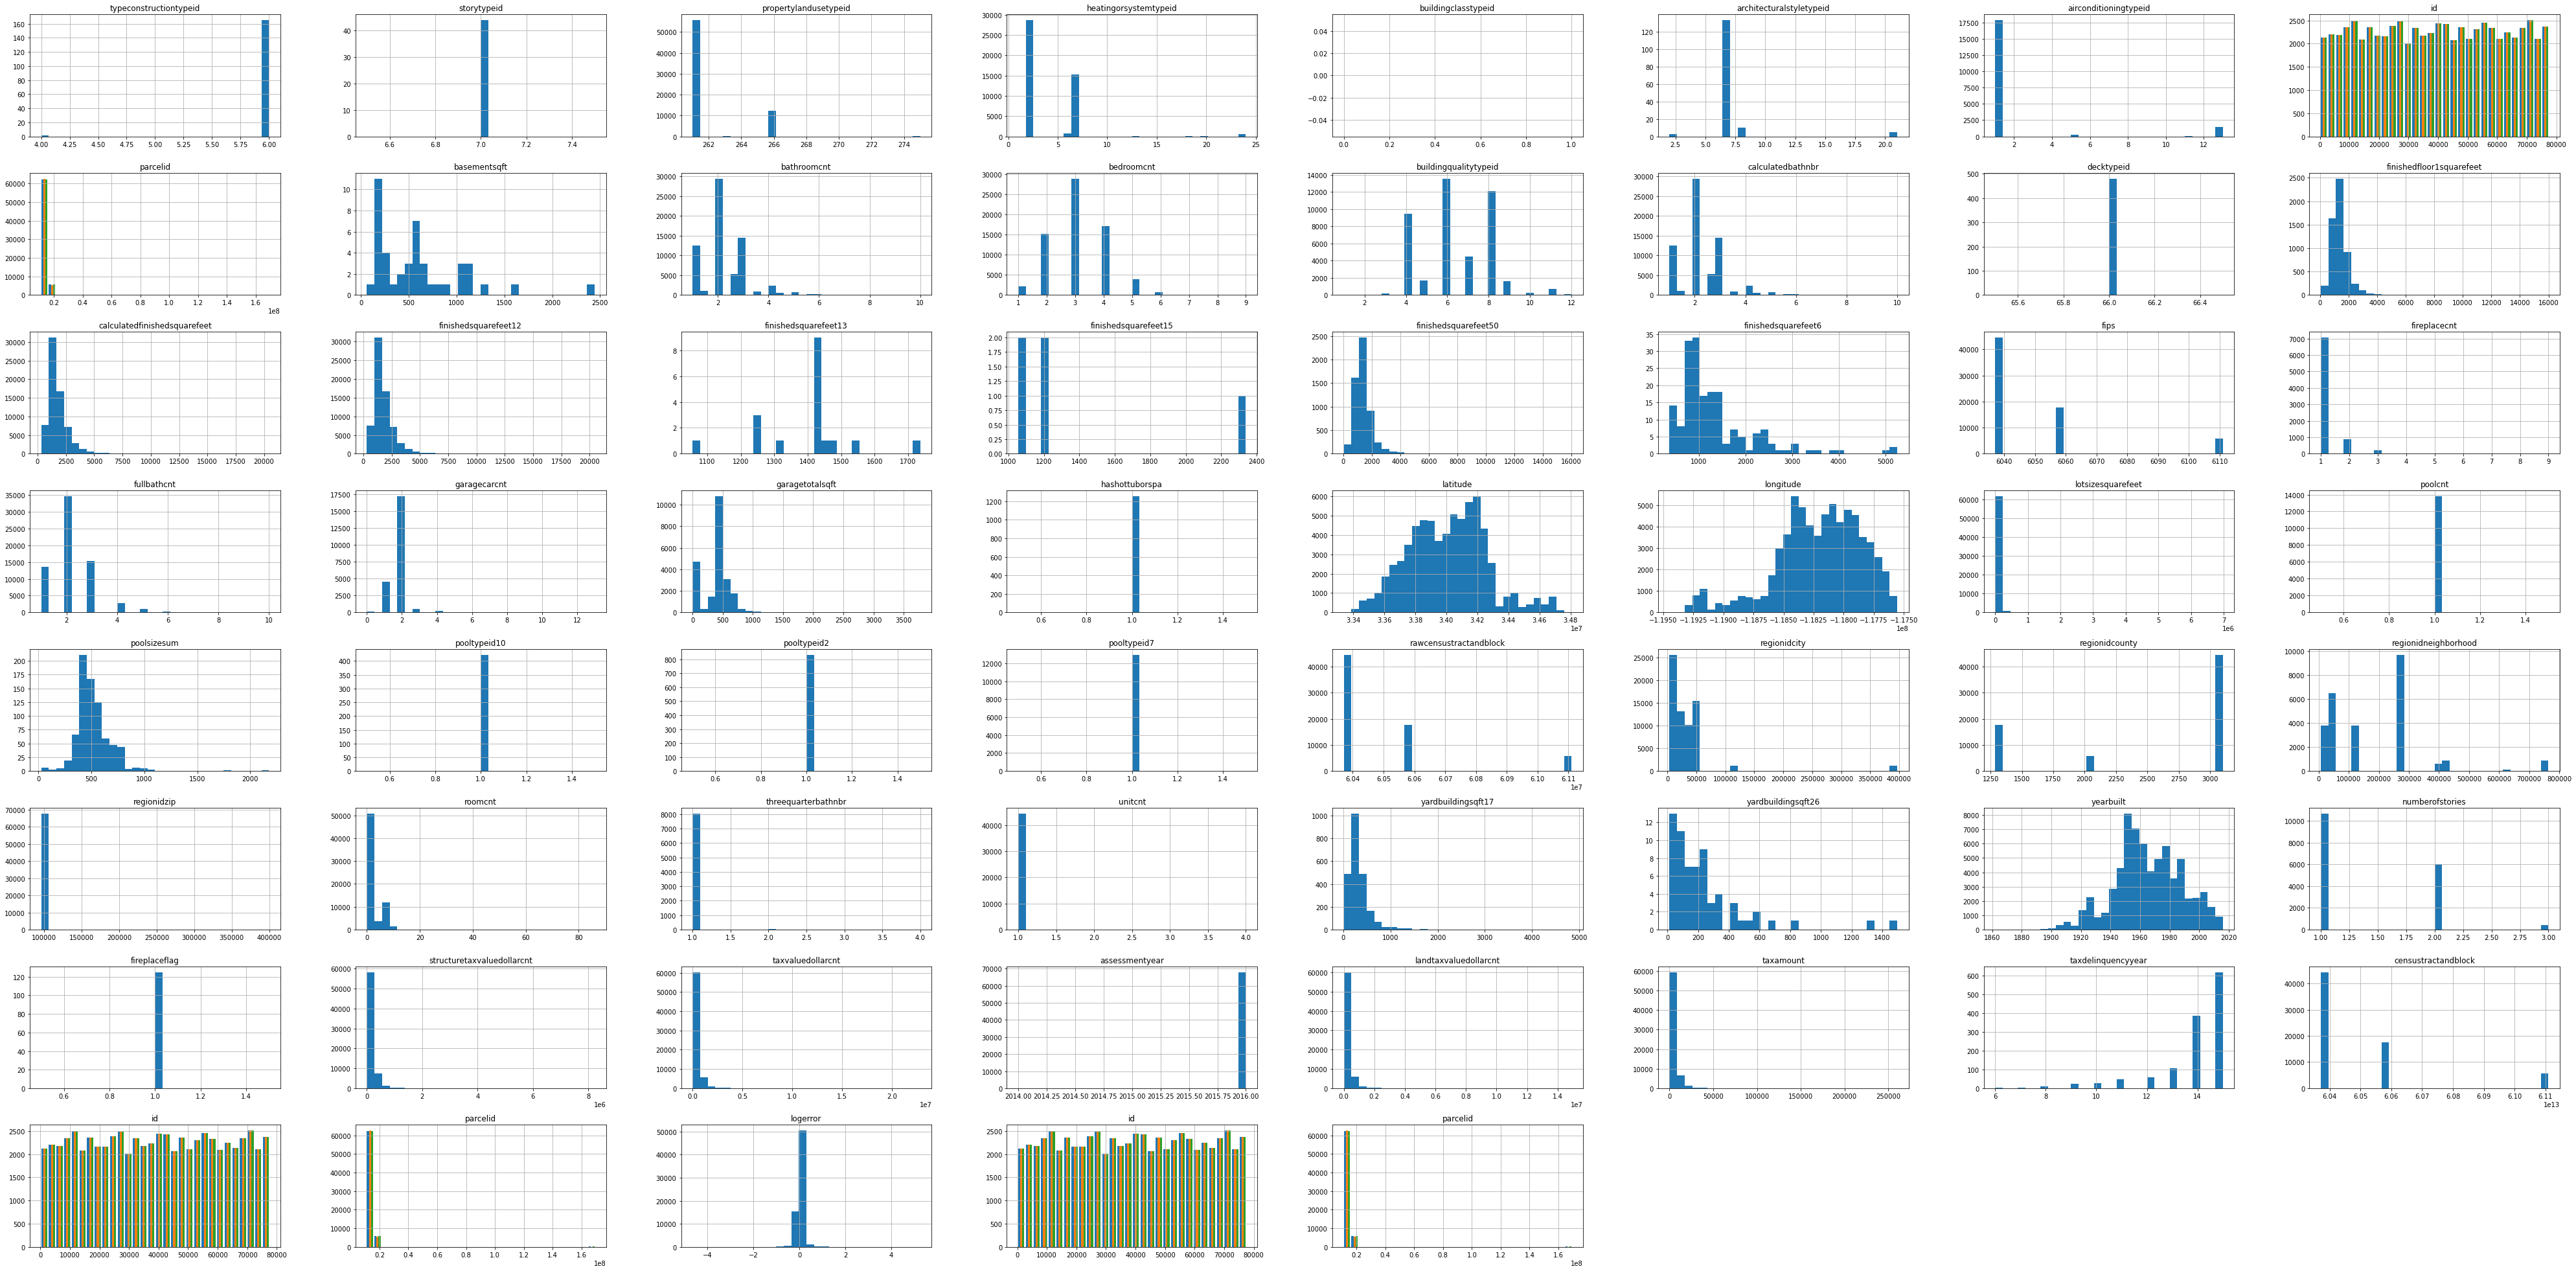

In [12]:
df.hist(figsize=(70, 35), bins=30)
plt.show()

********************************************************************* Acquire Takeaways

In [13]:
# how many null values are in each columns 
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,67875,99.76
storytypeid,67997,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,22889,33.64
buildingclasstypeid,68041,100.00
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,67997,99.94
typeconstructiondesc,67875,99.76


In [14]:
def drop_cols_null(df, max_missing_rows_pct=0.25):
    '''
    Takes in a DataFrame and a maximum percent for missing values and
    returns the passed DataFrame after removing any colums missing the
    defined max percent or more worth of rows
    '''
    
    # set threshold for axis=1 and drop cols
    thresh_col = math.ceil(df.shape[0] * (1 - max_missing_rows_pct))
    df = df.dropna(axis=1, thresh=thresh_col)

    return df

In [15]:
# I want to drop any column with more than 25% of the values missing
df = drop_cols_null(df)

In [16]:
# the above function removed 39 columns
df.shape

(68041, 34)

In [17]:
df.head()

,propertylandusetypeid,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,taxamount,censustractandblock,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,parcelid
20,261.00,20,11324547,2.00,4.00,2.00,"3,633.00","3,633.00","6,037.00",2.00,...,"6,941.39",NaN,20,12325145,0.04,2017-01-02,20,2017-01-02,Single Family Residential,11324547
30,266.00,30,11524947,2.00,2.00,2.00,"1,090.00","1,090.00","6,037.00",2.00,...,"6,165.36",NaN,30,12713253,0.02,2017-01-02,30,2017-01-02,Condominium,11524947
31,261.00,31,11544747,4.00,3.00,4.00,"1,620.00","1,620.00","6,037.00",4.00,...,"10,244.94",NaN,31,14338242,-0.02,2017-01-02,31,2017-01-02,Single Family Residential,11544747
33,261.00,33,11585547,2.00,3.00,2.00,"2,077.00","2,077.00","6,037.00",2.00,...,"7,924.68",NaN,33,12155445,-0.04,2017-01-02,33,2017-01-02,Single Family Residential,11585547
37,266.00,37,11617547,3.00,2.00,3.00,"2,735.00","2,735.00","6,037.00",3.00,...,"34,982.17",NaN,37,11682477,0.03,2017-01-02,37,2017-01-02,Condominium,11617547


In [18]:
df.columns

Index(['propertylandusetypeid', 'id', 'parcelid', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'id', 'parcelid', 'logerror',
       'transactiondate', 'id', 'last_trans_date', 'propertylandusedesc',
       'parcelid'],
      dtype='object')

In [19]:
df =df.drop(columns= ['propertylandusetypeid', 'id', 
       'calculatedbathnbr','rawcensustractandblock',
       'latitude', 'longitude',
        'propertycountylandusecode','regionidcounty','finishedsquarefeet12',
       'regionidzip', 'yearbuilt','id','censustractandblock','last_trans_date',
       'transactiondate', 'id','roomcnt','fullbathcnt'])


In [20]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'parcelid', 'logerror',
       'propertylandusedesc', 'parcelid'],
      dtype='object')

In [21]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,parcelid,logerror,propertylandusedesc,parcelid
20,11324547,2.00,4.00,"3,633.00","6,037.00","9,826.00","40,227.00","222,321.00","296,425.00","2,016.00","74,104.00","6,941.39",12325145,0.04,Single Family Residential,11324547
30,11524947,2.00,2.00,"1,090.00","6,037.00","40,247.00","12,447.00","232,897.00","357,568.00","2,016.00","124,671.00","6,165.36",12713253,0.02,Condominium,11524947
31,11544747,4.00,3.00,"1,620.00","6,037.00",NaN,"12,447.00","339,532.00","847,770.00","2,016.00","508,238.00","10,244.94",14338242,-0.02,Single Family Residential,11544747
33,11585547,2.00,3.00,"2,077.00","6,037.00","6,490.00","26,964.00","210,192.00","646,760.00","2,016.00","436,568.00","7,924.68",12155445,-0.04,Single Family Residential,11585547
37,11617547,3.00,2.00,"2,735.00","6,037.00",NaN,"12,447.00","757,582.00","2,922,104.00","2,016.00","2,164,522.00","34,982.17",11682477,0.03,Condominium,11617547


In [22]:
#check to see if they have the same values
df.parcelid.nunique()

parcelid    68041
parcelid    67880
parcelid    68041
dtype: int64

In [23]:
# here I am dropping the duplicate parcelid column
df = df.iloc[:,~df.columns.duplicated()]

In [24]:
# checking to make sure that happened
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror',
       'propertylandusedesc'],
      dtype='object')

In [25]:
#rename columns we might keep for better understanding
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
df.rename(columns={'bathroomcnt':'bathrooms','bedroomcnt': 'bedrooms','calculatedfinishedsquarefeet':
         'area','fips':'zipcode','lotsizesquarefeet': 'lot_area','taxvaluedollarcnt':'tax_value'})

,parcelid,bathrooms,bedrooms,area,zipcode,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc
20,11324547,2.00,4.00,"3,633.00","6,037.00","9,826.00","40,227.00","222,321.00","296,425.00","2,016.00","74,104.00","6,941.39",0.04,Single Family Residential
30,11524947,2.00,2.00,"1,090.00","6,037.00","40,247.00","12,447.00","232,897.00","357,568.00","2,016.00","124,671.00","6,165.36",0.02,Condominium
31,11544747,4.00,3.00,"1,620.00","6,037.00",NaN,"12,447.00","339,532.00","847,770.00","2,016.00","508,238.00","10,244.94",-0.02,Single Family Residential
33,11585547,2.00,3.00,"2,077.00","6,037.00","6,490.00","26,964.00","210,192.00","646,760.00","2,016.00","436,568.00","7,924.68",-0.04,Single Family Residential
37,11617547,3.00,2.00,"2,735.00","6,037.00",NaN,"12,447.00","757,582.00","2,922,104.00","2,016.00","2,164,522.00","34,982.17",0.03,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,11212539,3.00,4.00,"1,921.00","6,037.00","6,763.00","40,227.00","129,566.00","162,019.00","2,016.00","32,453.00","2,860.33",0.02,Single Family Residential
77610,11212639,3.00,4.00,"1,780.00","6,037.00","6,822.00","40,227.00","100,744.00","125,923.00","2,016.00","25,179.00","2,394.26",0.01,Single Family Residential
77611,11212962,2.00,3.00,"1,549.00","6,037.00","6,987.00","40,227.00","149,241.00","198,988.00","2,016.00","49,747.00","3,331.81",0.04,Single Family Residential
77612,11213162,3.00,3.00,"1,339.00","6,037.00","271,458.00","40,227.00","118,900.00","148,600.00","2,016.00","29,700.00","2,510.53",0.01,Condominium


In [26]:
df.shape

(68041, 14)

In [27]:
df = wrangle_functions.handle_missing_values(df)

In [28]:
df.shape

(68041, 14)

In [29]:
# replace nulls with median values for select columns
df.lotsizesquarefeet.fillna(7313, inplace = True)

In [30]:
# check for nulls values
df.isna().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet       5
fips                               0
lotsizesquarefeet                  0
regionidcity                    1237
structuretaxvaluedollarcnt        72
taxvaluedollarcnt                  4
assessmentyear                     0
landtaxvaluedollarcnt              4
taxamount                         81
logerror                           0
propertylandusedesc                0
dtype: int64

In [31]:
# drop columns with nulls for yearbuilt, taxvaluedollarcnt and taxamount
df.dropna()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc
20,11324547,2.00,4.00,"3,633.00","6,037.00","9,826.00","40,227.00","222,321.00","296,425.00","2,016.00","74,104.00","6,941.39",0.04,Single Family Residential
30,11524947,2.00,2.00,"1,090.00","6,037.00","40,247.00","12,447.00","232,897.00","357,568.00","2,016.00","124,671.00","6,165.36",0.02,Condominium
31,11544747,4.00,3.00,"1,620.00","6,037.00","7,313.00","12,447.00","339,532.00","847,770.00","2,016.00","508,238.00","10,244.94",-0.02,Single Family Residential
33,11585547,2.00,3.00,"2,077.00","6,037.00","6,490.00","26,964.00","210,192.00","646,760.00","2,016.00","436,568.00","7,924.68",-0.04,Single Family Residential
37,11617547,3.00,2.00,"2,735.00","6,037.00","7,313.00","12,447.00","757,582.00","2,922,104.00","2,016.00","2,164,522.00","34,982.17",0.03,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77609,11212539,3.00,4.00,"1,921.00","6,037.00","6,763.00","40,227.00","129,566.00","162,019.00","2,016.00","32,453.00","2,860.33",0.02,Single Family Residential
77610,11212639,3.00,4.00,"1,780.00","6,037.00","6,822.00","40,227.00","100,744.00","125,923.00","2,016.00","25,179.00","2,394.26",0.01,Single Family Residential
77611,11212962,2.00,3.00,"1,549.00","6,037.00","6,987.00","40,227.00","149,241.00","198,988.00","2,016.00","49,747.00","3,331.81",0.04,Single Family Residential
77612,11213162,3.00,3.00,"1,339.00","6,037.00","271,458.00","40,227.00","118,900.00","148,600.00","2,016.00","29,700.00","2,510.53",0.01,Condominium


In [32]:
# let's check dtypes again now that I have the columns I want
df.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
lotsizesquarefeet               float64
regionidcity                    float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
assessmentyear                  float64
landtaxvaluedollarcnt           float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
dtype: object

In [33]:
# correcting dtype
#df.propertylandusetypeid.astype(object)

In [34]:
# correcting dtype
df.fips.astype(object)

20                  6,037.00
30                  6,037.00
31                  6,037.00
33                  6,037.00
37                  6,037.00
                ...         
77609               6,037.00
77610               6,037.00
77611               6,037.00
77612               6,037.00
77613               6,037.00
Name: fips, Length: 68041, dtype: object

In [35]:
# correcting dtype
#df.regionidcounty.astype(object)

In [36]:
# I looked up the the average home size is 2,300 sqft so I will make that the cutoff 
# between a large and small home
# here I want to divide the homes and insert into a column those that are more than 2,300 sqft
df['large_home'] =(df['calculatedfinishedsquarefeet']> 2300).astype(int)

In [37]:
df.large_home.value_counts()

0    55092
1    12949
Name: large_home, dtype: int64

In [38]:
# check and change dtypes for each column
df.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
lotsizesquarefeet               float64
regionidcity                    float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
assessmentyear                  float64
landtaxvaluedollarcnt           float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
large_home                        int64
dtype: object

In [74]:
df.shape

(67833, 15)

In [77]:
#drop propertylanusetypeid, parcelid, propertylandusedesc, landtaxvaluedollarcnt,structuretaxvaluedollarcnt
df.drop(columns = ['parcelid', 'propertylandusedesc', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt'])

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,taxvaluedollarcnt,assessmentyear,taxamount,logerror,large_home
58273,3.00,4.00,"2,423.00","6,037.00","11,359.00","12,447.00","464,597.00","2,016.00","5,863.18",0.20,1
43294,3.00,3.00,"1,868.00","6,037.00","12,175.00","12,447.00","373,108.00","2,016.00","4,642.73",0.15,0
28470,3.00,3.00,"1,538.00","6,037.00","11,414.00","12,447.00","296,477.00","2,016.00","3,798.51",0.05,0
73149,2.00,4.00,"1,882.00","6,037.00","9,298.00","12,447.00","452,425.00","2,016.00","5,659.19",0.06,0
58274,2.00,4.00,"1,967.00","6,037.00","9,054.00","12,447.00","299,292.00","2,016.00","3,743.10",-0.01,0
...,...,...,...,...,...,...,...,...,...,...,...
44873,3.00,3.00,"1,695.00","6,059.00","7,313.00",NaN,"741,759.00","2,016.00","10,925.50",-0.02,0
59934,2.00,2.00,"1,458.00","6,059.00","7,313.00",NaN,"654,836.00","2,016.00","10,038.38",-0.04,0
74697,2.50,2.00,"1,452.00","6,059.00","7,313.00",NaN,"660,420.00","2,016.00","10,096.40",0.11,0
74698,2.50,2.00,"2,428.00","6,059.00","7,313.00",NaN,"2,378,948.00","2,016.00","25,311.78",-0.06,1


In [73]:
# remove duplicate entries
# sorting by first name
df.sort_values("parcelid", inplace=True)
 
# dropping duplicate values
df.drop_duplicates(keep=False,inplace=True)

In [75]:
# this shows me there were no existing duplicates
df.shape

(67833, 15)

In [41]:
# Columns to look for extreme outliers
df = df[df.taxvaluedollarcnt < 5_000_000]
df = df[df.calculatedfinishedsquarefeet < 8000]

In [42]:
# now I want to make a df with no outliers in any column for 
# comparison in exploration
def outlier_function(df,cols, k):
#function to detect and handle oulier using IQR rule
    df_out = pd.DataFrame()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr
        new_data = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
        missing_index = new_data.index.difference(df_out.index)
        df_out = df_out.append(new_data.loc[missing_index, : ])
    return df_out

In [43]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'propertylandusedesc',
       'large_home'],
      dtype='object')

In [44]:
#defining the columns to remove outliers from
cols = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet','lotsizesquarefeet','taxvaluedollarcnt',
       'taxamount']
k= .1
# create a df with no outliers 
df_no_outs =outlier_function(df,cols, k)

In [45]:
df_no_outs.shape

(54892, 15)

In [46]:
df.shape

(67833, 15)

In [47]:
# time to split the df in prepartion for exploration
def train_validate_test_split(df):
    train_and_validate, test = train_test_split(df, train_size=0.8, random_state=123)
    train, validate = train_test_split(train_and_validate, train_size=0.75, random_state=123)
    return train, validate, test

In [48]:
# I am splitting the df_no_outs into train, test, split but with no outliers
train_no_outs, validate_no_outs, test_no_outs = train_validate_test_split(df_no_outs)

In [49]:
# just the regular split of the regular df
train, validate, test = train_validate_test_split(df)

In [50]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc,large_home
69218,12944886,1.00,3.00,"1,265.00","6,037.00","10,047.00","14,542.00","106,329.00","233,689.00","2,016.00","127,360.00","2,829.90",-0.00,Single Family Residential,0
45775,17293211,3.00,4.00,"2,300.00","6,111.00","6,668.00","41,673.00","121,487.00","142,168.00","2,016.00","20,681.00","2,220.26",0.12,Single Family Residential,0
77206,11092044,2.00,3.00,"1,372.00","6,037.00","7,501.00","12,447.00","61,698.00","88,387.00","2,016.00","26,689.00","1,185.19",-0.01,Single Family Residential,0
69250,12951520,2.00,4.00,"1,580.00","6,037.00","8,692.00","14,542.00","74,701.00","373,517.00","2,016.00","298,816.00","4,342.05",-0.10,Single Family Residential,0
7742,12472620,2.00,3.00,"1,417.00","6,037.00","4,990.00","12,292.00","119,187.00","357,786.00","2,016.00","238,599.00","4,482.51",0.05,Single Family Residential,0


In [51]:
# now I will create a df that is scaled
_, train_scaled, validate_scaled, test_scaled = wrangle_functions.min_max_scaler(train, validate, test)

In [52]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc,large_home
69218,12944886,1.00,3.00,"1,265.00","6,037.00","10,047.00","14,542.00","106,329.00","233,689.00","2,016.00","127,360.00","2,829.90",-0.00,Single Family Residential,0
45775,17293211,3.00,4.00,"2,300.00","6,111.00","6,668.00","41,673.00","121,487.00","142,168.00","2,016.00","20,681.00","2,220.26",0.12,Single Family Residential,0
77206,11092044,2.00,3.00,"1,372.00","6,037.00","7,501.00","12,447.00","61,698.00","88,387.00","2,016.00","26,689.00","1,185.19",-0.01,Single Family Residential,0
69250,12951520,2.00,4.00,"1,580.00","6,037.00","8,692.00","14,542.00","74,701.00","373,517.00","2,016.00","298,816.00","4,342.05",-0.10,Single Family Residential,0
7742,12472620,2.00,3.00,"1,417.00","6,037.00","4,990.00","12,292.00","119,187.00","357,786.00","2,016.00","238,599.00","4,482.51",0.05,Single Family Residential,0


**************************************************************************************** Prepare Takeaways

In [53]:
############################################################################ EXPLORE

The topics of interest I would like to explore are:

    1. Is there a difference in logerror between small and large houses?(Viz size           against logerror -Stats test to confirm)
    
    2. Is there a relationship between lot size and logerror?

In [54]:
#train.drop(columns=['regionidcounty'])

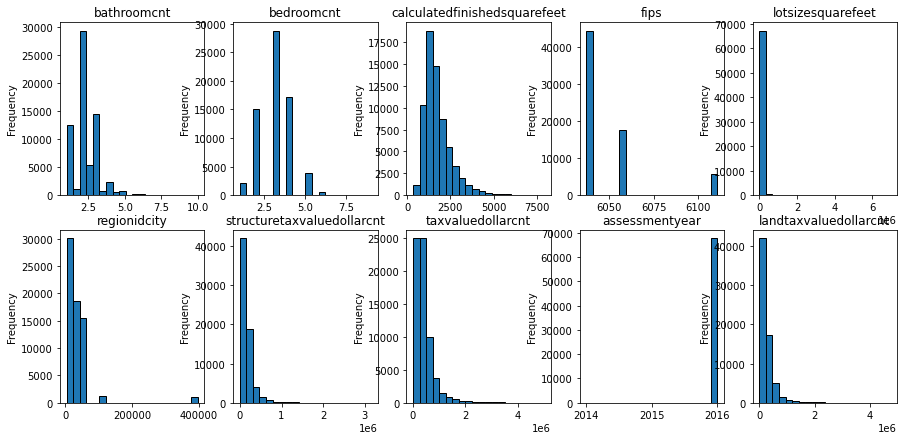

In [55]:
# First let's look at the distribution of each variable
fig, axs = plt.subplots(2, 5, figsize=(15, 7))

for ax, col in zip(axs.flatten(), train.select_dtypes(float)):
    df[col].plot.hist(ax=ax,bins=20, title=col, ec='black')

1. Is there a difference in logerror between small and large houses?(Viz size           against logerror -Stats test to confirm)

In [56]:
# choosing my features
X = train[['logerror', 'calculatedfinishedsquarefeet']]

In [57]:
# same for the scaled X
X_scaled = train_scaled[['logerror', 'calculatedfinishedsquarefeet']]

array([[<AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'calculatedfinishedsquarefeet'}>]],
      dtype=object)

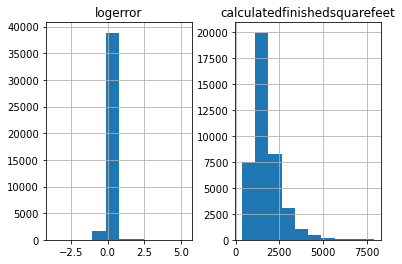

In [58]:
# look at distribution of logerror length and large_home

X.hist()

array([[<AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'calculatedfinishedsquarefeet'}>]],
      dtype=object)

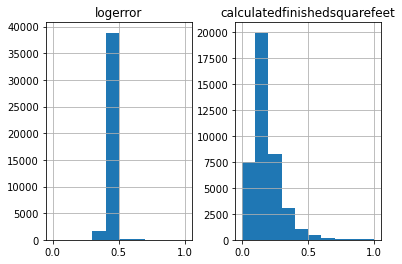

In [59]:
X_scaled.hist()

In [60]:
# sklearn implementation of KMeans

#define it
kmeans_scaled = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans_scaled.fit(X_scaled)

# Use/predict it
kmeans_scaled.predict(X_scaled)

array([0, 1, 0, ..., 1, 1, 0], dtype=int32)

In [61]:
# sklearn implementation of KMeans on unscaled X

#define it
kmeans = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans.fit(X)

# Use/predict it
kmeans.predict(X)

array([0, 1, 0, ..., 1, 1, 0], dtype=int32)

In [62]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['logerror', 'calculatedfinishedsquarefeet']
X['cluster'] = kmeans.predict(X[cluster_features])

X['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['cluster'] = kmeans.predict(X[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [63]:
# taking a peek at the unscaled data
X.head()

,logerror,calculatedfinishedsquarefeet,cluster,scaled_cluster
69218,-0.00,"1,265.00",0,0
45775,0.12,"2,300.00",1,1
77206,-0.01,"1,372.00",0,0
69250,-0.10,"1,580.00",0,0
7742,0.05,"1,417.00",0,0


In [64]:
X_scaled.head()

,logerror,calculatedfinishedsquarefeet,cluster,scaled_cluster
69218,0.41,0.12,0,0
45775,0.43,0.26,1,1
77206,0.41,0.13,0,0
69250,0.40,0.16,0,0
7742,0.42,0.14,0,0


In [65]:
centroids = X_scaled.groupby('cluster')['logerror', 'calculatedfinishedsquarefeet'].mean()

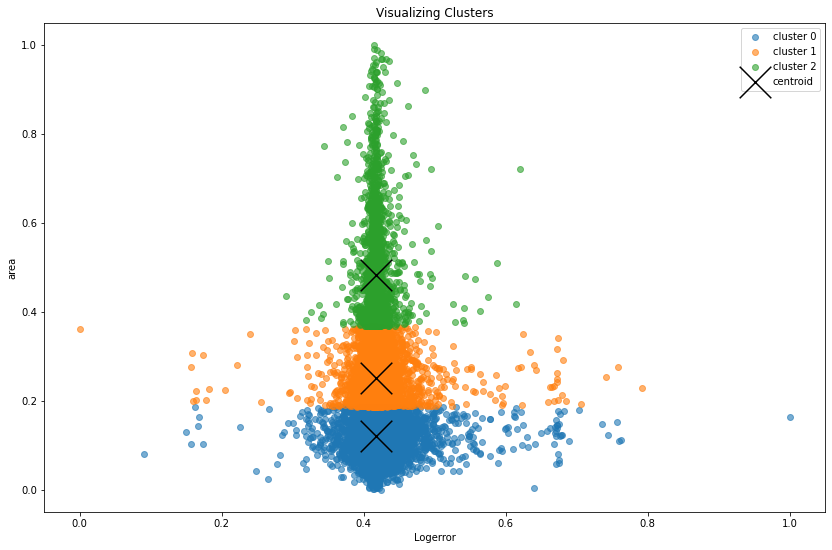

In [66]:
# now I am going to plot the scaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('cluster'):
    plt.scatter(subset.logerror, subset.calculatedfinishedsquarefeet, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='calculatedfinishedsquarefeet', x='logerror', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Logerror')
plt.ylabel('area')
plt.title('Visualizing Clusters')
plt.show()


In [67]:
centroids = X_scaled.groupby('scaled_cluster')['logerror', 'calculatedfinishedsquarefeet'].mean()

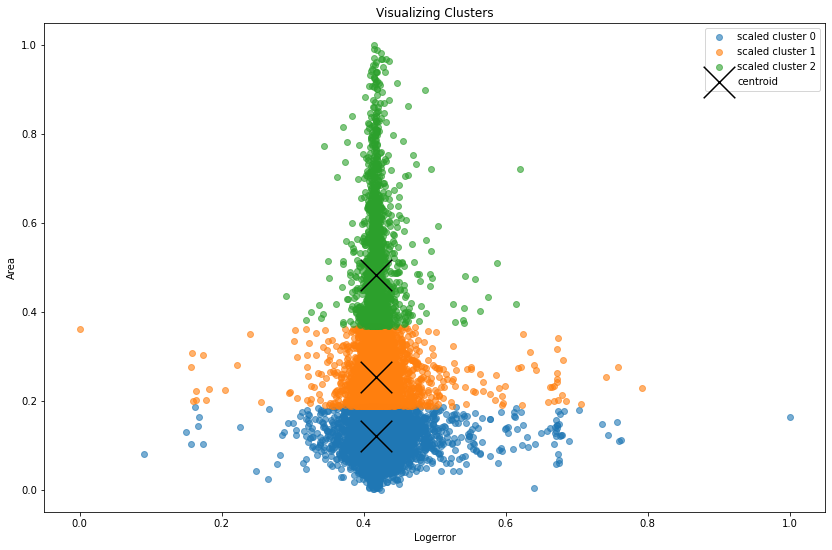

In [68]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.logerror, subset.calculatedfinishedsquarefeet, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='calculatedfinishedsquarefeet', x='logerror', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Logerror')
plt.ylabel('Area')
plt.title('Visualizing Clusters')
plt.show()

In [69]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc,large_home
69218,12944886,1.00,3.00,"1,265.00","6,037.00","10,047.00","14,542.00","106,329.00","233,689.00","2,016.00","127,360.00","2,829.90",-0.00,Single Family Residential,0
45775,17293211,3.00,4.00,"2,300.00","6,111.00","6,668.00","41,673.00","121,487.00","142,168.00","2,016.00","20,681.00","2,220.26",0.12,Single Family Residential,0
77206,11092044,2.00,3.00,"1,372.00","6,037.00","7,501.00","12,447.00","61,698.00","88,387.00","2,016.00","26,689.00","1,185.19",-0.01,Single Family Residential,0
69250,12951520,2.00,4.00,"1,580.00","6,037.00","8,692.00","14,542.00","74,701.00","373,517.00","2,016.00","298,816.00","4,342.05",-0.10,Single Family Residential,0
7742,12472620,2.00,3.00,"1,417.00","6,037.00","4,990.00","12,292.00","119,187.00","357,786.00","2,016.00","238,599.00","4,482.51",0.05,Single Family Residential,0


In [70]:
train_scaled.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,logerror,propertylandusedesc,large_home
69218,0.01,0.00,0.25,0.12,0.00,0.00,0.03,0.03,0.05,1.00,0.03,0.05,0.41,Single Family Residential,0.00
45775,0.04,0.22,0.38,0.26,1.00,0.00,0.10,0.04,0.03,1.00,0.00,0.04,0.43,Single Family Residential,0.00
77206,0.00,0.11,0.25,0.13,0.00,0.00,0.02,0.02,0.02,1.00,0.01,0.02,0.41,Single Family Residential,0.00
69250,0.01,0.11,0.38,0.16,0.00,0.00,0.03,0.02,0.07,1.00,0.06,0.07,0.40,Single Family Residential,0.00
7742,0.01,0.11,0.25,0.14,0.00,0.00,0.02,0.04,0.07,1.00,0.05,0.07,0.42,Single Family Residential,0.00


In [71]:
target = train.logerror
def target_heat(df, target, method='pearson'):
    '''
    Use seaborn to create heatmap with coeffecient annotations to
    visualize correlation between all variables
    '''

    # define variable for corr matrix
    heat_churn = train.corr()[target][:-1]
    # set figure size
    fig, ax = plt.subplots(figsize=(30, 1))
    # define cmap for chosen color palette
    cmap = sns.diverging_palette(h_neg=220, h_pos=13, sep=25, as_cmap=True)
    # plot matrix turned to DataFrame
    sns.heatmap(heat_churn.to_frame().T, cmap=cmap, center=0,
                annot=True, fmt=".1g", cbar=False, square=True)
    #  improve readability of xticks, remove churn ytick
    plt.xticks(ha='right', va='top', rotation=35, rotation_mode='anchor')
    plt.yticks(ticks=[])
    # set title and print graphic
    plt.title(f'Correlation to {target}\n')
    plt.show()


In [72]:
# create heatmap to find any obvious correlations to target
explore.target_heat(train.drop(
    columns=['propertylandusetypeid','parcelid','regionidcounty',''
             ', 'property_id', 'year_built']), 'log_error')

SyntaxError: invalid syntax (<ipython-input-72-0bd5ab5d56ca>, line 4)